## Importing the relevant library

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

For this simulation, we will try using both Pytorch and Keras to see how they stack against each other

## Downloading the dataset

In [2]:
# Transformations applied on the dataset (converting to tensor and normalizing)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Downloading the MNIST dataset for training and testing
train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100,
                                          shuffle=False, num_workers=2)

## Printing a sample of 5 images

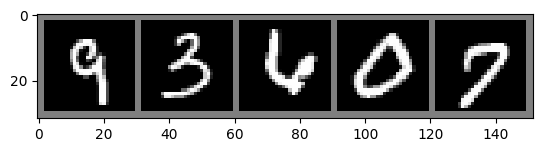

In [5]:
# 3. Print a sample of 5 images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Getting some random training images
dataiter = iter(train_loader)
images, labels = next(iter(train_loader))

# Showing 5 images
imshow(torchvision.utils.make_grid(images[:5]))

# # Defining the CNN model based on the paper using PyTorch Method

In [6]:
# CNN model based on "Communication-Efficient Learning of Deep Networks from Decentralized Data"

cnn = nn.Sequential(
    # Layer 1: Convolutional layer with 32 filters, 5x5 kernel, stride of 1, and ReLU activation
    nn.Conv2d(1, 32, 5, stride=1),
    nn.ReLU(),
    # Layer 2: Max pooling with 2x2 kernel and stride of 2
    nn.MaxPool2d(2, 2),
    # Layer 3: Convolutional layer with 64 filters, 5x5 kernel, stride of 1, and ReLU activation
    nn.Conv2d(32, 64, 5, stride=1),
    nn.ReLU(),
    # Layer 4: Max pooling with 2x2 kernel and stride of 2
    nn.MaxPool2d(2, 2),
    # Flattening the tensor before feeding it into the fully connected layer
    nn.Flatten(),
    # Layer 5: Fully connected layer with 512 units and ReLU activation
    nn.Linear(64 * 4 * 4, 512),
    nn.ReLU(),
    # Layer 6: Fully connected layer with 10 units (for 10 output classes)
    nn.Linear(512, 10)
)

print(cnn)


Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=10, bias=True)
)


In [8]:
import torch.optim as optim

# Move the model to the device
cnn = cnn.to(device)

# Set the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)

# Adjust learning rate during training
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial learning rate decayed by 10 every 50 epochs"""
    lr = 0.1 * (0.1 ** (epoch // 50))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Number of epochs
num_epochs = 200

# Train the CNN model
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn(inputs)
        # Calculate loss
        loss = loss_function(outputs, labels)
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}")

print("Finished training the CNN model")



Epoch 1, Loss: 0.08598741213262352
Epoch 2, Loss: 0.041083254471886904
Epoch 3, Loss: 0.03444581552981011
Epoch 4, Loss: 0.031602944134404724
Epoch 5, Loss: 0.027049394093143442
Epoch 6, Loss: 0.028618493826070335
Epoch 7, Loss: 0.026918025603954447
Epoch 8, Loss: 0.02674050654876434
Epoch 9, Loss: 0.026569154609169345
Epoch 10, Loss: 0.025320614635274977
Epoch 11, Loss: 0.023841124325602626
Epoch 12, Loss: 0.024820176782717075
Epoch 13, Loss: 0.024314920421456918
Epoch 14, Loss: 0.025116471052266814
Epoch 15, Loss: 0.022294397143802294
Epoch 16, Loss: 0.024505533153618066
Epoch 17, Loss: 0.022009988683469903
Epoch 18, Loss: 0.021782199515170457
Epoch 19, Loss: 0.025752266226530384
Epoch 20, Loss: 0.02315253838072143
Epoch 21, Loss: 0.02304718744494797
Epoch 22, Loss: 0.02121050353787723
Epoch 23, Loss: 0.021856384824447257
Epoch 24, Loss: 0.022824267214309656
Epoch 25, Loss: 0.022225706858589548
Epoch 26, Loss: 0.023140228576982433
Epoch 27, Loss: 0.021662739373908457
Epoch 28, Loss: 

In [11]:
# Set the model to evaluation mode
cnn.eval()

# Initialize variables to count correct predictions and total predictions
correct = 0
total = 0

# Disable gradient calculations during evaluation (saves memory and speeds up computation)
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = cnn(inputs)

        # Get the predicted class by selecting the class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Update the total number of predictions
        total += labels.size(0)

        # Update the number of correct predictions
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = correct / total * 100
print(f"Accuracy of the CNN model on the test dataset: {accuracy:.2f}%")


Accuracy of the CNN model on the test dataset: 99.44%


# Using the Keras Module 

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((10000, 28, 28, 1)).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN model
cnn = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
cnn.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
num_epochs = 10
cnn.fit(x_train, y_train, epochs=num_epochs, batch_size=32)

# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn.evaluate(x_test, y_test)
print(f"Accuracy of the CNN model on the test dataset: {test_accuracy * 100:.2f}%")


11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.4483 - accuracy: 0.8735
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1133 - accuracy: 0.9661
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0789 - accuracy: 0.9764
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0625 - accuracy: 0.9812
Epoch 5/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0525 - accuracy: 0.9837
Epoch 6/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0454 - accuracy: 0.9860
Epoch 7/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0404 - accuracy: 0.9876
Epoch 8/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0348 - accuracy: 0.9894
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0320 - accuracy: 0.9900
Epoch 10